## Photon transport in water cylinder

### Imports and configuration

In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sas_pet import SimulationConfig, run_annihilations, intersect_cylinder

In [27]:
xcom_path = Path("../data/xcomH2O.tsv")

cfg = SimulationConfig(
    cylinder_radius_cm=10.0,
    cylinder_half_len_cm=15.0,
    rng_seed=42,
    show_progress=True,
)

n_annihilations = 1000

### Run photon transport

In [28]:
photons_df, lors_df = run_annihilations(
    n_annihilations,
    cfg=cfg,
    xcom_path=xcom_path,
)

Simulating annihilations:   0%|          | 0/1000 [00:00<?, ?it/s]

### Filter to photons that actually exit

In [29]:
df = photons_df.copy()

if "exited" in df.columns:
    df = df[df["exited"].to_numpy(bool)]

if "absorbed" in df.columns:
    df = df[~df["absorbed"].to_numpy(bool)]

df = df.dropna(subset=["exit_x", "exit_y", "exit_z", "n_x", "n_y", "n_z"])
df = df.reset_index(drop=True)

print("Photons exiting the cylinder:", len(df), "out of", n_annihilations * 2, f"({len(df) / (n_annihilations * 2) * 100:.2f}%)")

Photons exiting the cylinder: 1883 out of 2000 (94.15%)


__Change so axis convention match the one in article__

In [30]:
axis_map = {"exit_x": "exit_z", "exit_y": "exit_x", "exit_z": "exit_y"}
direction_map = {"n_x": "n_z", "n_y": "n_x", "n_z": "n_y"}

df.rename(columns=axis_map, inplace=True)
df.rename(columns=direction_map, inplace=True)

### Project onto fixed cylinder

In [31]:
R_DET_CM = 15.0
RING_LENGTH_CM = 30.0
Z_MAX_DET_CM = 0.5 * RING_LENGTH_CM

from sas_pet import intersect_cylinder

px, py, pz = intersect_cylinder(
    df["exit_x"].to_numpy(float),
    df["exit_y"].to_numpy(float),
    df["exit_z"].to_numpy(float),
    df["n_x"].to_numpy(float),
    df["n_y"].to_numpy(float),
    df["n_z"].to_numpy(float),
    radius_cm=R_DET_CM,
    half_length_cm=Z_MAX_DET_CM,
)

df_proj = df.copy()
df_proj["det_x"] = px
df_proj["det_y"] = py
df_proj["det_z"] = pz
df_proj = df_proj.dropna(subset=["det_x", "det_y", "det_z"]).reset_index(drop=True)

len(df_proj), df_proj.head()

(1315,
   photon_ID  annihilation_ID  photon_index       n_z       n_x       n_y  \
 0       0_1                0             1 -0.775602  0.313423  0.547912   
 1       2_2                2             2  0.870098 -0.212496 -0.444719   
 2       3_1                3             1 -0.459582 -0.256663  0.850240   
 3       3_2                3             2  0.459582  0.256663 -0.850240   
 4       4_1                4             1 -0.357222 -0.128234 -0.925175   
 
      exit_z    exit_x    exit_y  theta_eff_deg  ...  theta_track_deg  \
 0 -2.103128 -7.952120  6.063315      76.064504  ...        52.419384   
 1 -0.755721  6.722163 -7.403548      83.090125  ...       126.290505   
 2 -5.257761 -2.686483  9.632383       1.139266  ...        37.597004   
 3  0.958272  7.486030 -6.630185      37.225926  ...        57.500314   
 4 -3.997061 -0.830153 -9.965483       3.037747  ...        51.938792   
 
    n_object_scatters  scattered  exited  absorbed  detected  E_exit_keV  \
 0           

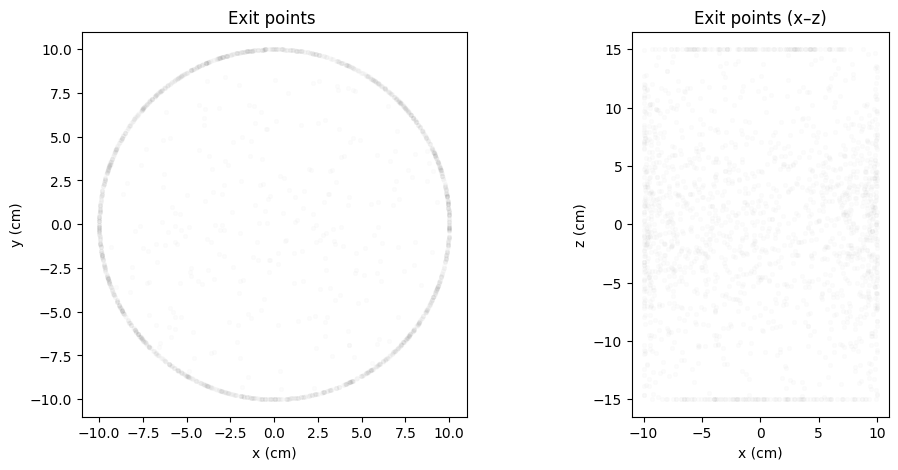

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(11.5, 5.0))
axs[0].scatter(df["exit_x"], df["exit_y"], s=8, alpha=0.01, color="black")
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlabel("x (cm)")
axs[0].set_ylabel("y (cm)")
axs[0].set_title("Exit points ")

axs[1].scatter(df["exit_x"], df["exit_z"], s=8, alpha=0.01, color="black")
axs[1].set_aspect("equal", adjustable="box")
axs[1].set_xlabel("x (cm)")
axs[1].set_ylabel("z (cm)")
axs[1].set_title("Exit points (x–z)")
plt.show()

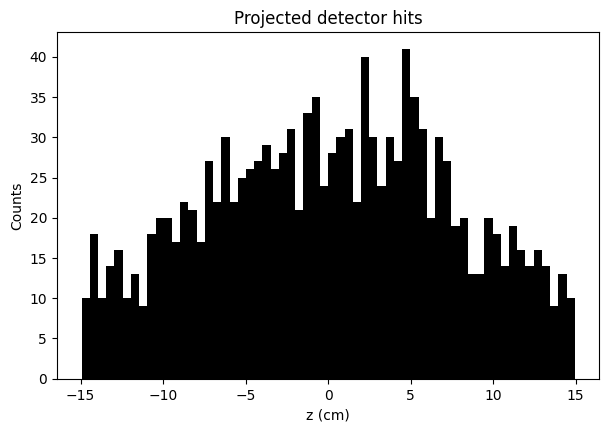

In [33]:
fig, ax = plt.subplots(figsize=(7.0, 4.5))
ax.hist(df_proj["det_z"].to_numpy(float), bins=60, color="black")
ax.set_xlabel("z (cm)")
ax.set_ylabel("Counts")
ax.set_title("Projected detector hits")
plt.show()